In [1]:
import numpy as np
from HARK.ConsumptionSaving.ConsPortfolioModel import SequentialPortfolioConsumerType
import matplotlib.pyplot as plt
from sharkfin.population import SharkPopulation, SharkPopulationSolution
from sharkfin.utilities import price_dividend_ratio_random_walk
from simulate.parameters import WHITESHARK, LUCAS0

In [2]:
from sharkfin.expectations import UsualExpectations
from sharkfin.markets import MockMarket

In [3]:
from scipy.optimize import fsolve
import seaborn as sns
import pandas as pd

## Setup

In [4]:
LUCAS0
LUCAS0['aNrmInitStd'] = 0.0

In [5]:
dividend_growth_rate = 1.000203
dividend_std = 0.011983

rng = 234675

market_args = {
    "dividend_growth_rate": dividend_growth_rate,
    "dividend_std": dividend_std,
    "rng": rng,
    "price_to_dividend_ratio": price_dividend_ratio_random_walk(
        LUCAS0["DiscFac"], LUCAS0["CRRA"], dividend_growth_rate, dividend_std
    ),
}

subjective_return: 0.9999130331113283


In [6]:
ue = UsualExpectations(MockMarket(**market_args))
ue.calculate_risky_expectations()
risky_expectations = ue.risky_expectations()

In [7]:
parameter_dict = LUCAS0.copy()

In [8]:
parameter_dict.update(risky_expectations)

In [9]:
PARAMS = parameter_dict # a0h.parameters

PARAMS["aNrmInitMean"] = 1
PARAMS["aNrmInitStd"] = 0.00
PARAMS["T_sim"] = 5000
PARAMS["PermGroFac"] = [PARAMS["PermGroFac"]]
PARAMS["AgentCount"] = 2000
PARAMS["sim_common_Rrisky"] = False

#PARAMS['LivPrb'] = [1.0]
PARAMS['DiscFac'] =  0.99 # * 0.995 * .9

#PARAMS['TranShkStd'] = [1.0]

PARAMS['RiskyCount'] = 9


at = SequentialPortfolioConsumerType(**PARAMS)
at.track_vars += ["aNrm", "cNrm", "mNrm", "Risky", "Share", "aLvl", "pLvl"]
at.solve()

In [10]:
parameter_dict

{'cycles': 0,
 'aNrmInitStd': 0.0,
 'aNrmInitMean': 1,
 'LivPrb': [0.9949620563926881],
 'PermGroFac': [1.0],
 'pLvlInitMean': 0.0,
 'pLvlInitStd': 0.0,
 'Rfree': 1.0,
 'TranShkStd': [0],
 'PermShkStd': [0],
 'UnempPrb': 0.0,
 'CRRA': 3,
 'DiscFac': 0.99,
 'ex_post': None,
 'AgentCount': 2000,
 'num_per_type': 1000,
 'RiskyAvg': 1.0175492133848216,
 'RiskyStd': 0.09283741339989003,
 'T_sim': 5000,
 'sim_common_Rrisky': False,
 'RiskyCount': 9}

## Using the solution functions

In [11]:
cFunc = at.solution[0].cFuncAdj
ShareFunc = at.solution[0].ShareFuncAdj

In [12]:
def expected_increase(mNrm):
    share = ShareFunc(mNrm)

    aNrm = mNrm - cFunc(mNrm)

    mNrm_next = (
        aNrm
        * (share * at.parameters["RiskyAvg"] + (1 - share) * at.parameters["Rfree"])
        + 1
    )

    gain = mNrm_next - aNrm

    return gain

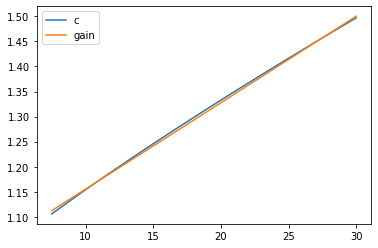

In [13]:
mNrm = np.linspace(7.5, 30, 1000)

plt.plot(mNrm, cFunc(mNrm), label="c")

plt.plot(mNrm, expected_increase(mNrm), label="gain")

plt.legend()

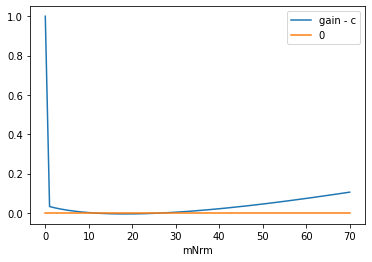

In [14]:
mNrm = np.linspace(0, 70, 1000)

plt.plot(mNrm, expected_increase(mNrm) - cFunc(mNrm), label="gain - c")
plt.plot(mNrm, np.zeros(mNrm.shape), label="0")
plt.xlabel('mNrm')

plt.legend()

In [15]:
def diff(mNrm):
    return expected_increase(mNrm) - cFunc(mNrm)

m0, m1 = fsolve(diff, [0,50])

In [16]:
m0

10.720200498237338

In [17]:
m1

27.442653694314835

In [18]:
np.log(m0)

2.372129858661535

Given $m$, what is the value of $a$ that implies that the consumer has $m$.

$m_t = r_p * a_{t-1} / (\psi * G) + \theta$

$a_{t-1} = (m_t - \theta) \frac{\psi G}{r_p}$

Two equations:

$a_{t-1} = (m_t - \theta) \frac{\psi G}{(1 - \hat{\alpha}_{t-1}) R + \hat{\alpha}_{t-1}(a_{t-1}) \eta}$

$\hat{\alpha}_{t-1}(a_{t-1}) = \text{arg}\max_{\alpha \in [0,1]} ...$ Sequential portfolio model. Convex optimization.

In [38]:
#(approximately, working backwards fom m0 to a0...
a0 = (m0 - 1) / at.parameters['Rfree']

In [54]:
np.log(a0)

2.2742062456502787

In [39]:
at.assign_parameters(aNrmInitMean = np.log(a0)) # np.log(m0))
2.274

at.initialize_sim()
at.simulate()

{'aNrm': array([[ 9.55256057,  9.55256057,  9.55256057, ...,  9.55256057,
          9.55256057,  9.55256057],
        [11.11626423,  9.5133656 ,  9.27159877, ...,  8.15377036,
         10.39629328,  8.15377036],
        [11.06853553, 11.07069733,  9.2340024 , ...,  7.43426472,
          9.80984274,  8.33447318],
        ...,
        [ 3.72884153,  1.35247835,  1.43635047, ...,  5.56683407,
          4.45170103,  3.02482545],
        [ 3.19816254,  1.25725369,  1.25046029, ...,  5.69692541,
          3.81273114,  2.77441761],
        [ 3.20129401,  1.27675764,  1.33868877, ...,  5.20104622,
          4.16279621,  2.93342945]]),
 'cNrm': array([[1.16763992, 1.16763992, 1.16763992, ..., 1.16763992, 1.16763992,
         1.16763992],
        [1.19722088, 1.16689032, 1.16225742, ..., 1.14062247, 1.18367925,
         1.14062247],
        [1.19632711, 1.1963676 , 1.16153593, ..., 1.12650067, 1.17255022,
         1.1441448 ],
        ...,
        [1.05086186, 0.99901121, 1.00089892, ..., 1.0890

In [62]:
(at.history['Share'] < 1).sum()

0

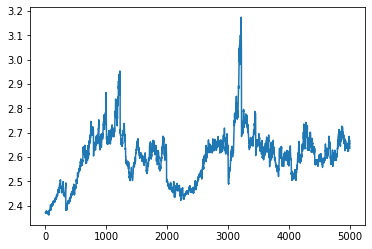

In [40]:
df_mNrm = pd.DataFrame(at.history['mNrm'])

#plt.plot(np.log(df_mNrm[df_mNrm > m1].mean(axis=1)))
#plt.plot(np.log(df_mNrm[df_mNrm < m1].mean(axis=1)))


plt.plot(np.log(df_mNrm.mean(axis=1)))

In [41]:
2.7 ** 700

9.00813552271619e+301

Text(0, 0.5, 'log mNm')

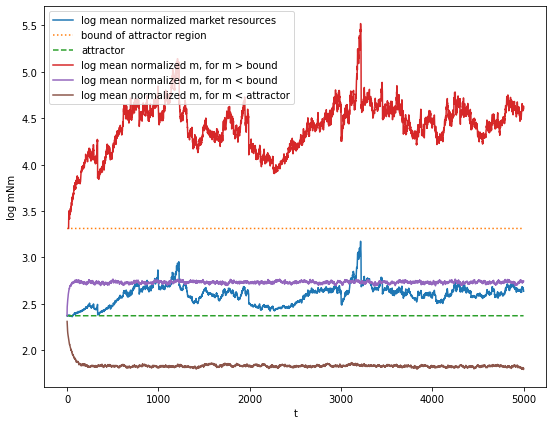

In [42]:
plt.figure(figsize=(9,7))
plt.plot(np.log(np.mean(at.history['mNrm'], axis = 1)), label = "log mean normalized market resources")
plt.plot(np.ones(np.sum(at.history['mNrm'], axis = 1).shape) * np.log(m1), ':', label="bound of attractor region")
plt.plot(np.ones(np.sum(at.history['mNrm'], axis = 1).shape) * np.log(m0), '--', label="attractor")
plt.plot(np.log(df_mNrm[df_mNrm > m1].mean(axis=1)), label = "log mean normalized m, for m > bound")
plt.plot(np.log(df_mNrm[(df_mNrm > m0) & (df_mNrm < m1)].mean(axis=1)), label = "log mean normalized m, for m < bound")
plt.plot(np.log(df_mNrm[df_mNrm < m0].mean(axis=1)), label = "log mean normalized m, for m < attractor")
plt.legend()
plt.xlabel('t')
plt.ylabel('log mNm')

In [43]:
upper_mNrm = df_mNrm[df_mNrm > m1].sum(axis=1)
middle_mNrm = df_mNrm[(df_mNrm < m1) & (df_mNrm > m0)].sum(axis=1)
lower_mNrm = df_mNrm[df_mNrm < m0].sum(axis=1)
total_mNrm = df_mNrm.sum(axis=1)

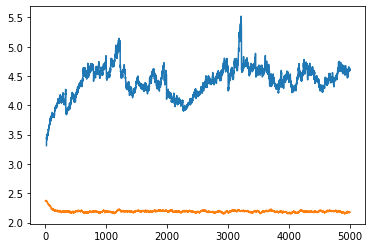

In [44]:
df_mNrm = pd.DataFrame(at.history['mNrm'])

plt.plot(np.log(df_mNrm[df_mNrm > m1].mean(axis=1)))
plt.plot(np.log(df_mNrm[df_mNrm < m1].mean(axis=1)))

Text(0.5, 1.0, 'Percentage of resources held, by class')

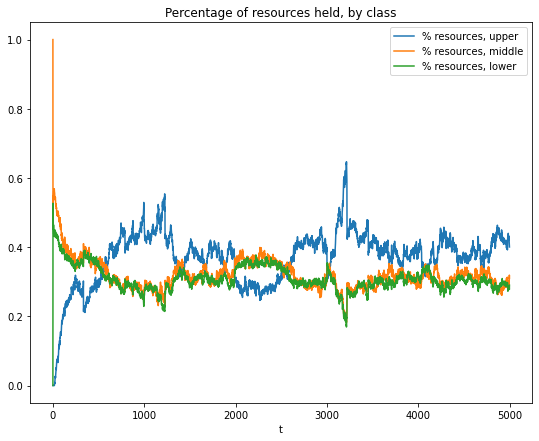

In [45]:
plt.figure(figsize=(9,7))
plt.plot(upper_mNrm / total_mNrm, label="% resources, upper"), '--',
plt.plot(middle_mNrm / total_mNrm, label="% resources, middle"), '--',
plt.plot(lower_mNrm / total_mNrm, label="% resources, lower"), '--',
plt.legend()
plt.xlabel('t')
plt.title('Percentage of resources held, by class')

Text(0.5, 1.0, 'Percentage population, by class')

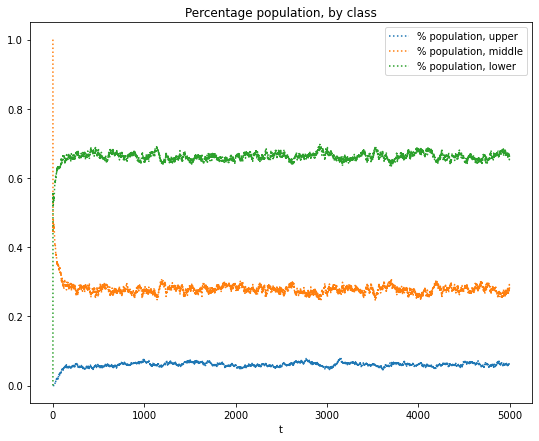

In [46]:
plt.figure(figsize=(9,7))

plt.plot((df_mNrm > m1).sum(axis=1) / at.parameters['AgentCount'], ':',
         label = "% population, upper")

plt.plot(((df_mNrm < m1) & (df_mNrm > m0)).sum(axis=1) / at.parameters['AgentCount'], ':',
         label = "% population, middle")

plt.plot((df_mNrm < m0).sum(axis=1)  / at.parameters['AgentCount'], ':',
         label = "% population, lower")

plt.legend()
plt.xlabel('t')
plt.title("Percentage population, by class")



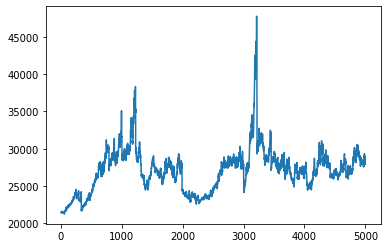

In [47]:
plt.plot(at.history['mNrm'].sum(1))

In [48]:
#sns.lineplot(data = df, x = 't', y='value')

Text(0.5, 6.79999999999999, 'log mNrm')

<Figure size 648x504 with 0 Axes>

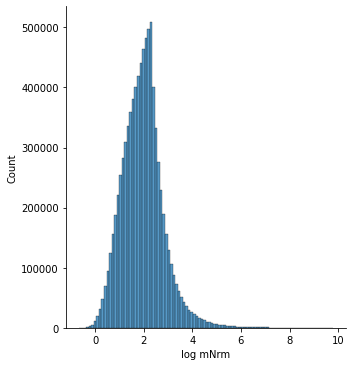

In [49]:
plt.figure(figsize=(9,7))
out = sns.displot(np.log(at.history['aNrm'][750:,:].flatten()), bins = 100)
plt.xlabel('log mNrm')

In [56]:
np.log([m0, m1])

np.log(a0)

2.2742062456502787

In [55]:
np.log(np.mean(at.history['aNrm'][750:,:]))

2.5343609452382707

In [58]:
np.log(np.quantile(at.history['aNrm'][750:,:].flatten(), .5))

1.959128346411599